In [ ]:
#To analyze and derive actionable insights from a marketing campaign dataset , focusing on campaign performance, customer segments, channels, time, and geography.

!pip install pyspark


In [3]:
# Import Libraries
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, avg, count, to_date, desc
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd


In [4]:
# Create Spark session
spark = SparkSession.builder.appName("MarketingCampaignAnalysis").getOrCreate()
# Download CSV using pandas and save locally
url = "https://raw.githubusercontent.com/ArchanaInsights/Datasets/main/marketing_campaign.csv"
df_pd = pd.read_csv(url)
df_pd.to_csv("marketing_campaign.csv", index=False)

# Load into PySpark DataFrame
df = spark.read.csv("marketing_campaign.csv", header=True, inferSchema=True)

df.show(10)


+-----------+-------------------+-------------+---------------+--------+------------+---------------+----------------+-------+----------------+--------+------+-----------+----------------+-------------------+----------+
|Campaign_ID|            Company|Campaign_Type|Target_Audience|Duration|Channel_Used|Conversion_Rate|Acquisition_Cost|    ROI|        Location|Language|Clicks|Impressions|Engagement_Score|   Customer_Segment|      Date|
+-----------+-------------------+-------------+---------------+--------+------------+---------------+----------------+-------+----------------+--------+------+-----------+----------------+-------------------+----------+
|          1|           TechCorp|        Email|    Women 25-34| 30 days|    Facebook|    5.294193574|            9344|  62.94|         Houston| English|  3045|      67836|               5|   Tech Enthusiasts|01-01-2023|
|          2|Innovate Industries|   Influencer|    Women 35-44| 45 days|  Google Ads|    3.326375241|            8783|  

## **Descriptive Analysis**

In [5]:
# Get number of rows and columns
print(f"Total Rows: {df.count()}")
print(f"Total Columns: {len(df.columns)}")

# Descriptive statistics for numerical columns
df.describe().show()


df.printSchema()

Total Rows: 22029
Total Columns: 16
+-------+-----------------+-----------------+-------------+---------------+--------+------------+------------------+-----------------+------------------+----------------+--------+------------------+------------------+------------------+----------------+----------+
|summary|      Campaign_ID|          Company|Campaign_Type|Target_Audience|Duration|Channel_Used|   Conversion_Rate| Acquisition_Cost|               ROI|        Location|Language|            Clicks|       Impressions|  Engagement_Score|Customer_Segment|      Date|
+-------+-----------------+-----------------+-------------+---------------+--------+------------+------------------+-----------------+------------------+----------------+--------+------------------+------------------+------------------+----------------+----------+
|  count|            22029|            22029|        22029|          22029|   22029|       22029|             22029|            22029|             22029|           22029

In [6]:
#Data exploration

# Count of unique Campaign_IDs
df.select("Campaign_ID").distinct().count()

# Unique values in Location and Customer Segment
df.select("Location").distinct().show(truncate=False)
df.select("Customer_Segment").distinct().show(truncate=False)

# Count of each Campaign Type
df.groupBy("Campaign_Type").count().orderBy("count", ascending=False).show()

# Count of each Channels Used
df.groupBy("Channel_Used").count().orderBy("count", ascending=False).show()


+----------------+
|Location        |
+----------------+
|Dallas          |
|Los Angeles     |
|San Francisco   |
|Chicago         |
|Atlanta         |
|Seattle         |
|Houston         |
|Washington, D.C.|
|Miami           |
|New York        |
+----------------+

+-------------------+
|Customer_Segment   |
+-------------------+
|Outdoor Adventurers|
|Health & Wellness  |
|Fashionistas       |
|Foodies            |
|Tech Enthusiasts   |
+-------------------+

+-------------+-----+
|Campaign_Type|count|
+-------------+-----+
|      Display| 4450|
|       Search| 4441|
| Social Media| 4412|
|        Email| 4388|
|   Influencer| 4338|
+-------------+-----+

+------------+-----+
|Channel_Used|count|
+------------+-----+
|    Facebook| 3742|
|  Google Ads| 3694|
|     Website| 3688|
|   Instagram| 3649|
|     YouTube| 3632|
|       Email| 3624|
+------------+-----+



## **Exploratory Data Analysis (EDA) & Visualizations**

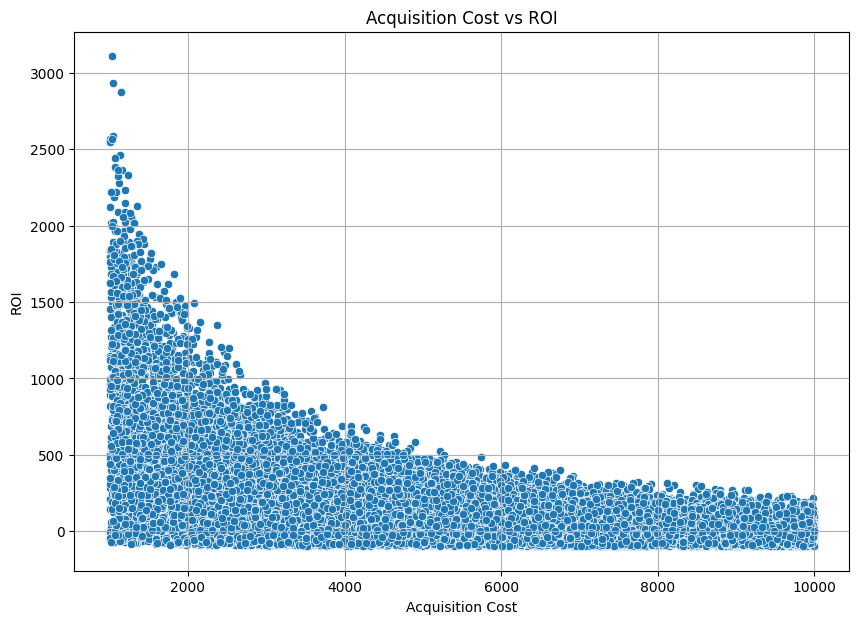

In [7]:
#Scatter Plot: Acquisition Cost vs ROI

# Convert selected columns to Pandas for plotting
scatter_df = df.select("Acquisition_Cost", "ROI").dropna().toPandas()

# Plot
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10,7))
sns.scatterplot(data=scatter_df, x="Acquisition_Cost", y="ROI")
plt.title("Acquisition Cost vs ROI")
plt.xlabel("Acquisition Cost")
plt.ylabel("ROI")
plt.grid(True)
plt.show()


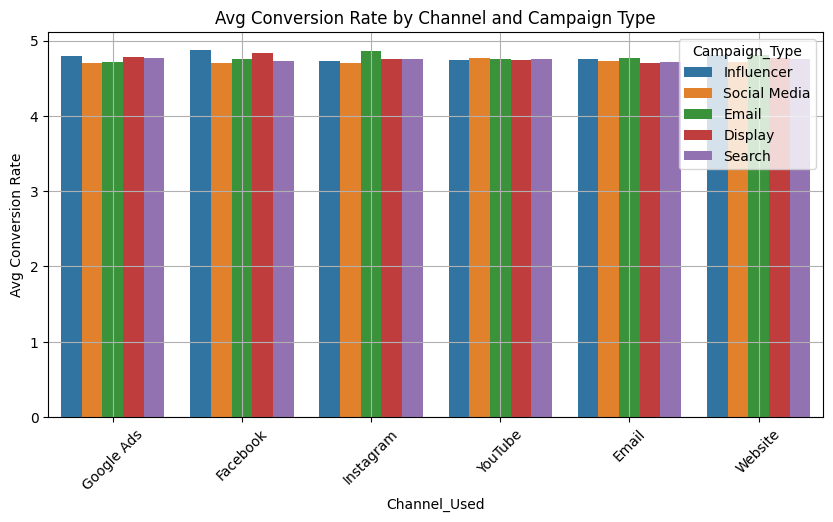

In [12]:
#Bar Chart: Avg Conversion Rate by Channel Used, grouped by Campaign Type

# Group in PySpark
avg_conv = df.groupBy("Channel_Used", "Campaign_Type") \
             .agg(avg("Conversion_Rate").alias("Avg_Conversion_Rate")) \
             .dropna()

# Convert to Pandas
avg_conv_pd = avg_conv.toPandas()

# Plot
plt.figure(figsize=(10,5))
sns.barplot(data=avg_conv_pd, x="Channel_Used", y="Avg_Conversion_Rate", hue="Campaign_Type")
plt.title("Avg Conversion Rate by Channel and Campaign Type")
plt.xticks(rotation=45)
plt.ylabel("Avg Conversion Rate")
plt.grid(True)
plt.show()


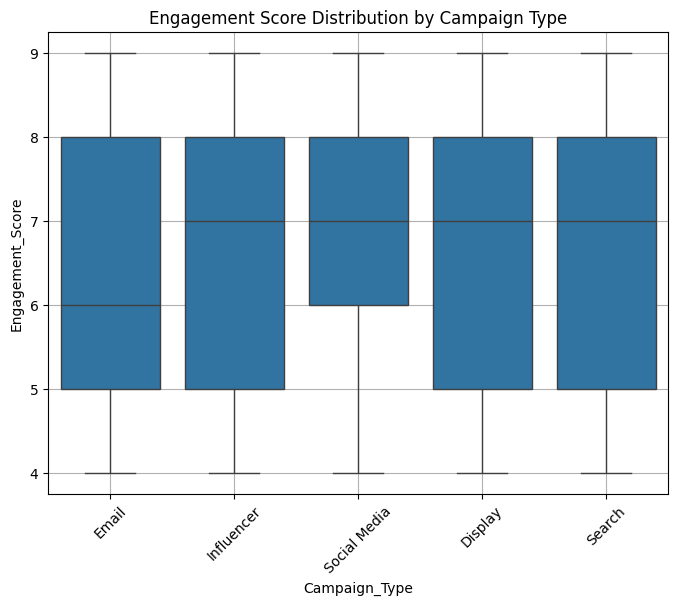

In [7]:
#Box Plot: Engagement Score by Campaign Type

box_df = df.select("Engagement_Score", "Campaign_Type").dropna().toPandas()

plt.figure(figsize=(8,6))
sns.boxplot(data=box_df, x="Campaign_Type", y="Engagement_Score")
plt.title("Engagement Score Distribution by Campaign Type")
plt.xticks(rotation=45)
plt.grid(True)
plt.show()


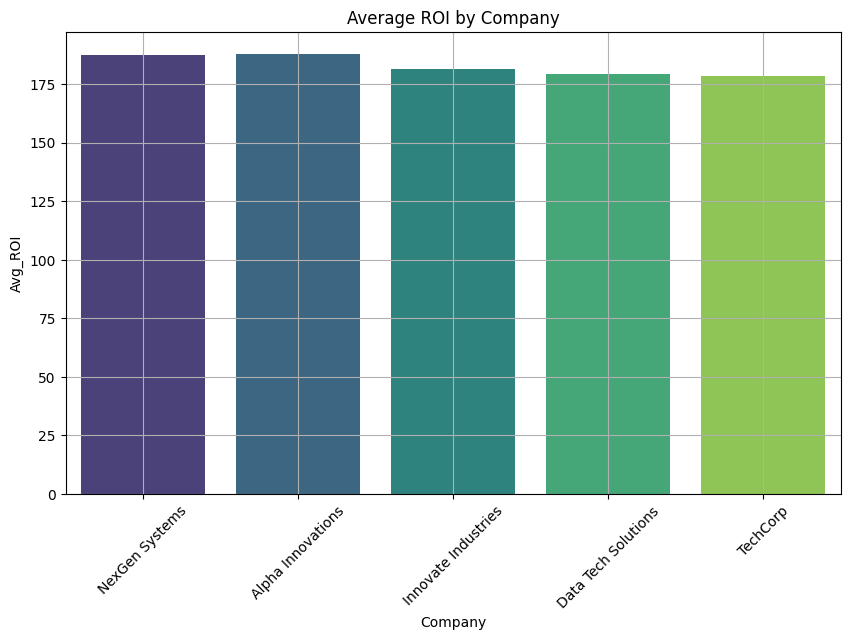

In [12]:
#Bar Chart: Average ROI by Company

avg_roi = df.groupBy("Company").agg(avg("ROI").alias("Avg_ROI"))
avg_roi_pd = avg_roi.toPandas()

plt.figure(figsize=(10,6))
sns.barplot(data= avg_roi_pd, x="Company", y="Avg_ROI", hue="Company", palette="viridis", dodge=False, legend=False)
plt.title("Average ROI by Company")
plt.xticks(rotation=45)
plt.grid(True)
plt.show()



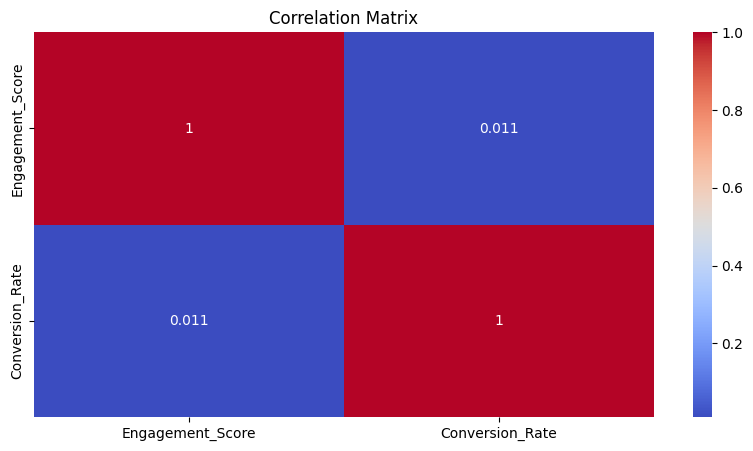

In [14]:
#Heatmap: Correlation between Engagement Score and Conversion Rate

heat_df = df.select("Engagement_Score", "Conversion_Rate").dropna().toPandas()

plt.figure(figsize=(10,5))
sns.heatmap(heat_df.corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Matrix")
plt.show()


## **Customer segmentation Analysis**

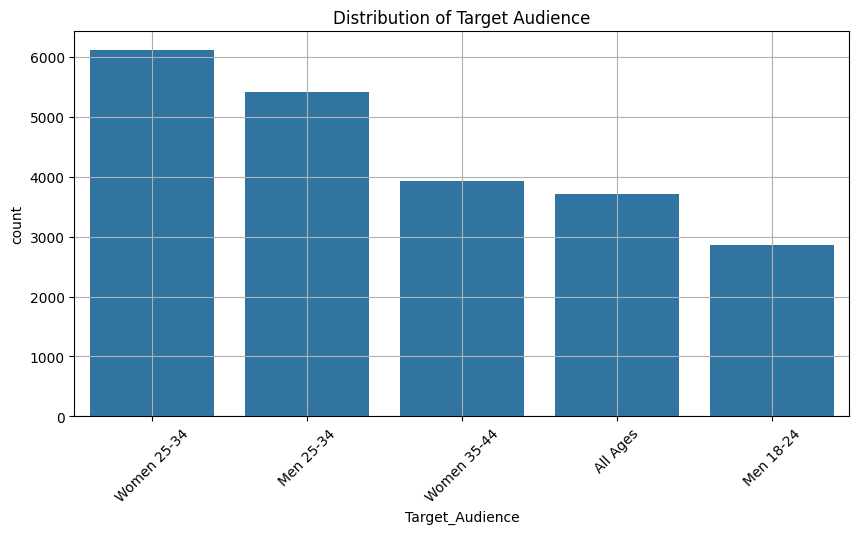

In [15]:
#Count Plot: Distribution of Target_Audience

target_df = df.select("Target_Audience").dropna().toPandas()

plt.figure(figsize=(10,5))
sns.countplot(data=target_df, x="Target_Audience", order=target_df['Target_Audience'].value_counts().index)
plt.title("Distribution of Target Audience")
plt.xticks(rotation=45)
plt.grid(True)
plt.show()


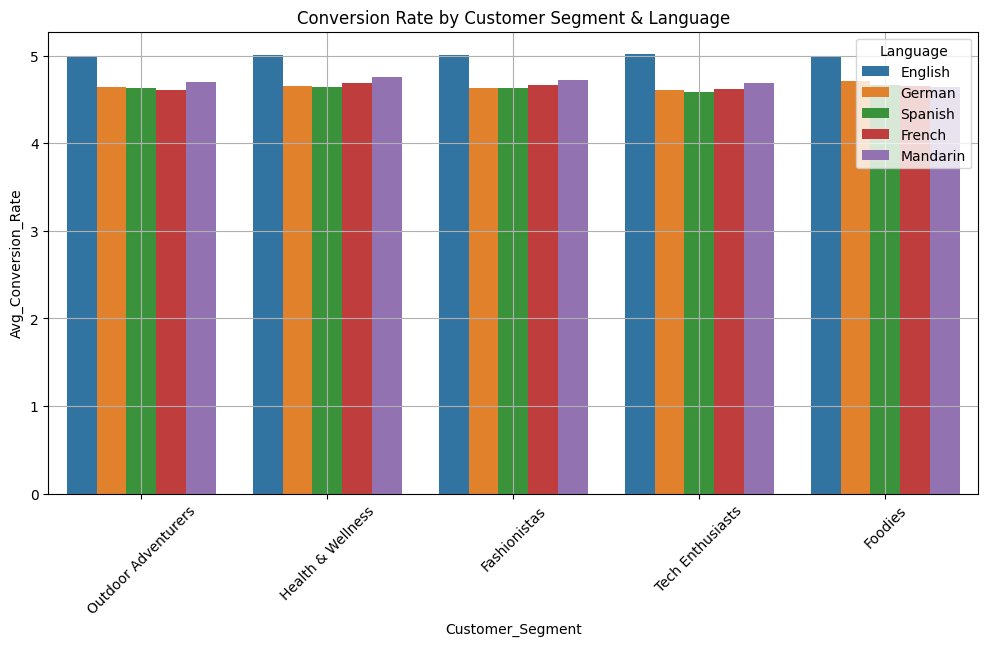

In [16]:
#Bar Chart: Highest Conversion Rate per Customer Segment by Language

segment_conv = df.groupBy("Customer_Segment", "Language") \
                 .agg(avg("Conversion_Rate").alias("Avg_Conversion_Rate")) \
                 .dropna()

segment_conv_pd = segment_conv.toPandas()

plt.figure(figsize=(12,6))
sns.barplot(data=segment_conv_pd, x="Customer_Segment", y="Avg_Conversion_Rate", hue="Language")
plt.title("Conversion Rate by Customer Segment & Language")
plt.xticks(rotation=45)
plt.grid(True)
plt.show()


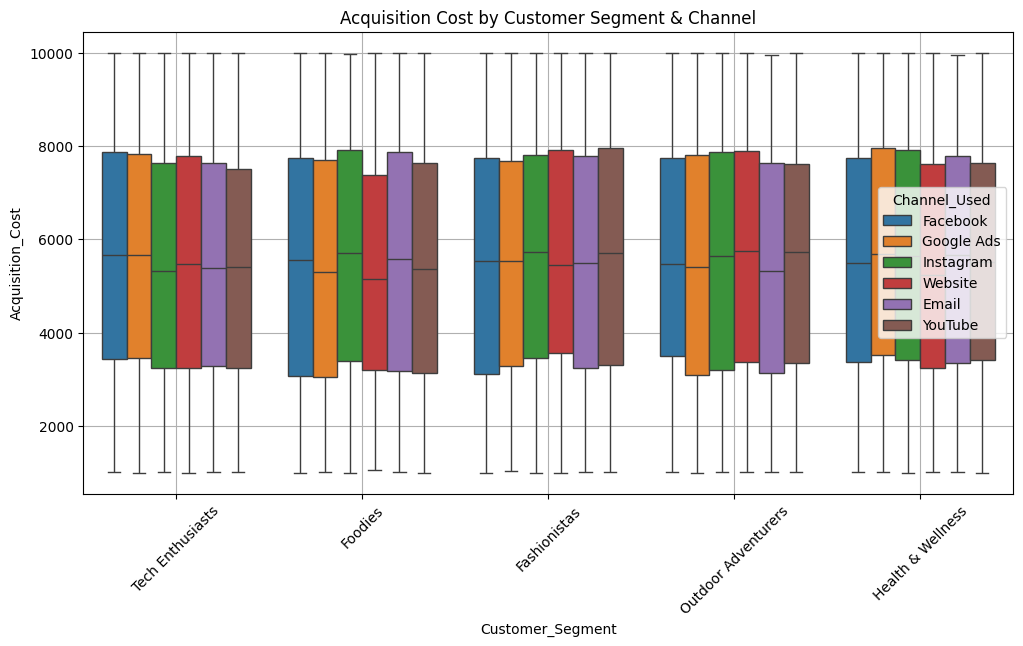

In [17]:
#Box Plot: Acquisition Cost across Customer Segment grouped by Channel Used

cost_df = df.select("Customer_Segment", "Channel_Used", "Acquisition_Cost").dropna().toPandas()

plt.figure(figsize=(12,6))
sns.boxplot(data=cost_df, x="Customer_Segment", y="Acquisition_Cost", hue="Channel_Used")
plt.title("Acquisition Cost by Customer Segment & Channel")
plt.xticks(rotation=45)
plt.grid(True)
plt.show()


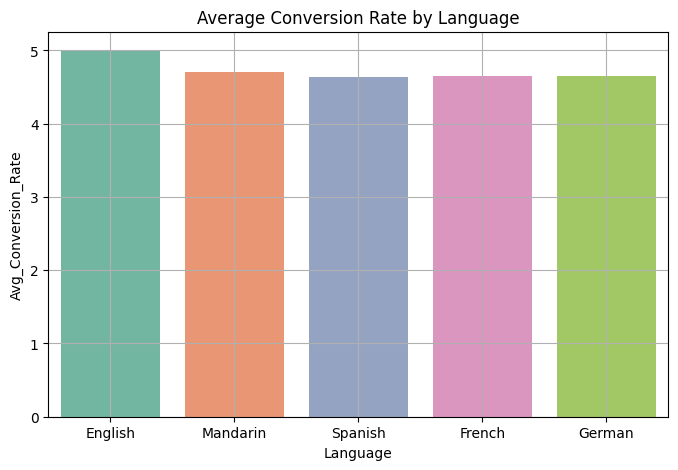

In [19]:
# Bar Chart: Avg Conversion Rate by Language

lang_conv = df.groupBy("Language") \
              .agg(avg("Conversion_Rate").alias("Avg_Conversion_Rate")) \
              .dropna()

lang_conv_pd = lang_conv.toPandas()

plt.figure(figsize=(8,5))
sns.barplot(data=lang_conv_pd, x="Language", y="Avg_Conversion_Rate", hue="Language", palette="Set2", dodge=False, legend=False)
plt.title("Average Conversion Rate by Language")
plt.grid(True)
plt.show()



## **Channel Effectiveness Analysis**

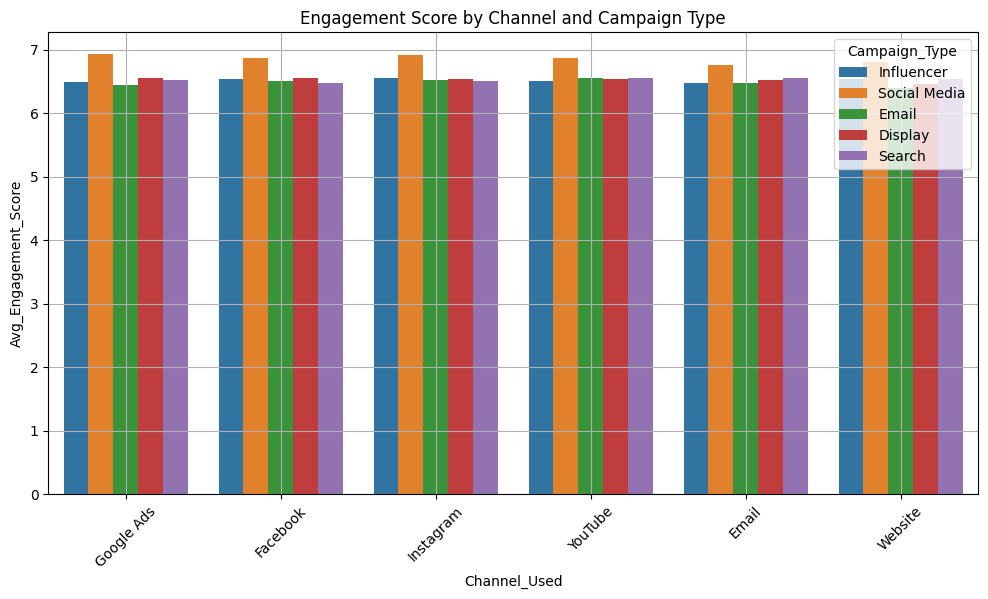

In [20]:
#Bar Chart: Engagement Score by Channel Used grouped by Campaign Type

engage_df = df.groupBy("Channel_Used", "Campaign_Type") \
              .agg(avg("Engagement_Score").alias("Avg_Engagement_Score")) \
              .dropna().toPandas()

plt.figure(figsize=(12,6))
sns.barplot(data=engage_df, x="Channel_Used", y="Avg_Engagement_Score", hue="Campaign_Type")
plt.title("Engagement Score by Channel and Campaign Type")
plt.xticks(rotation=45)
plt.grid(True)
plt.show()


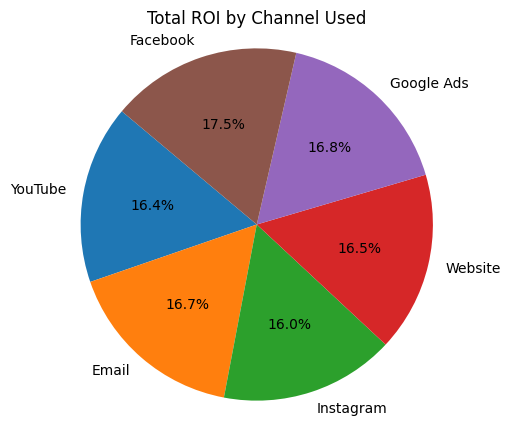

In [22]:
#Pie Chart: Total ROI by Channel Used

roi_df = df.groupBy("Channel_Used") \
           .agg({"ROI": "sum"}) \
           .withColumnRenamed("sum(ROI)", "Total_ROI") \
           .dropna().toPandas()

# Plot Pie Chart
plt.figure(figsize=(5,5))
plt.pie(roi_df["Total_ROI"], labels=roi_df["Channel_Used"], autopct='%1.1f%%', startangle=140)
plt.title("Total ROI by Channel Used")
plt.axis('equal')
plt.show()


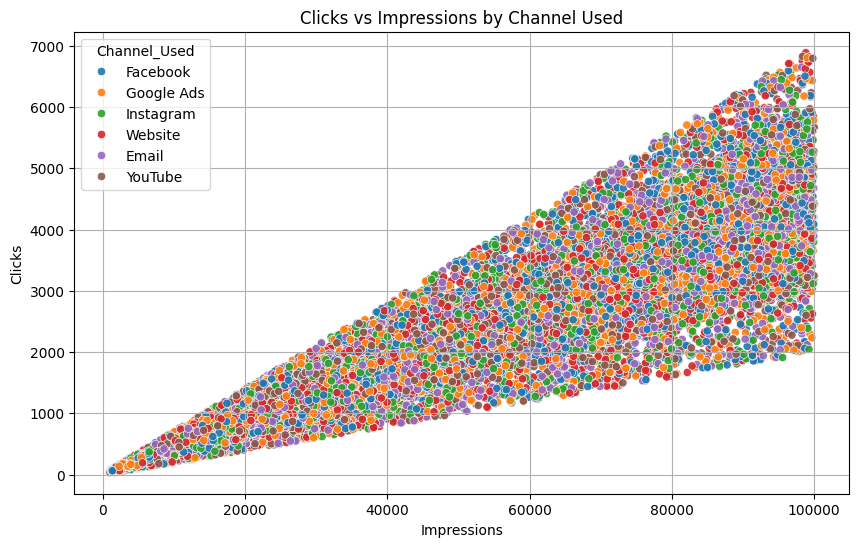

In [26]:
#Scatter Plot: Clicks vs Impressions by Channel Used

clicks_df = df.select("Channel_Used", "Clicks", "Impressions").dropna().toPandas()

plt.figure(figsize=(10,6))
sns.scatterplot(data=clicks_df, x="Impressions", y="Clicks", hue="Channel_Used", alpha=0.9)
plt.title("Clicks vs Impressions by Channel Used")
plt.grid(True)
plt.show()


## **Time based Analysis**

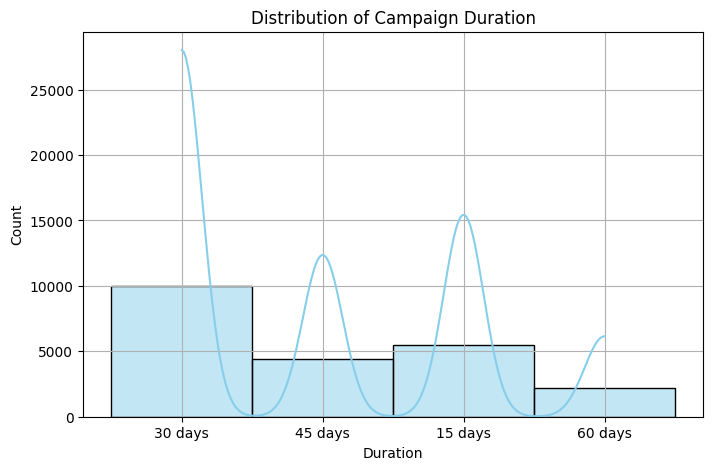

In [27]:

#Histogram: Distribution of Campaign Duration

duration_df = df.select("Duration").dropna().toPandas()

plt.figure(figsize=(8,5))
sns.histplot(data=duration_df, x="Duration", bins=15, kde=True, color="skyblue")
plt.title("Distribution of Campaign Duration")
plt.grid(True)
plt.show()



In [ ]:
#   Time-Based Analysis

# - ✅ A histogram was successfully plotted to analyze the **distribution of campaign durations**, providing insight into how long most marketing efforts lasted.

# - ❌ However, **date-aligned trend analysis** (e.g., Conversion Rate over time, Engagement Score over time) was not possible, as the dataset lacks valid rows where both `Date` and performance metrics are available.

# 📌 This emphasizes the importance of proper timestamp tracking in future campaign data collection

## **Geographic Analysis**

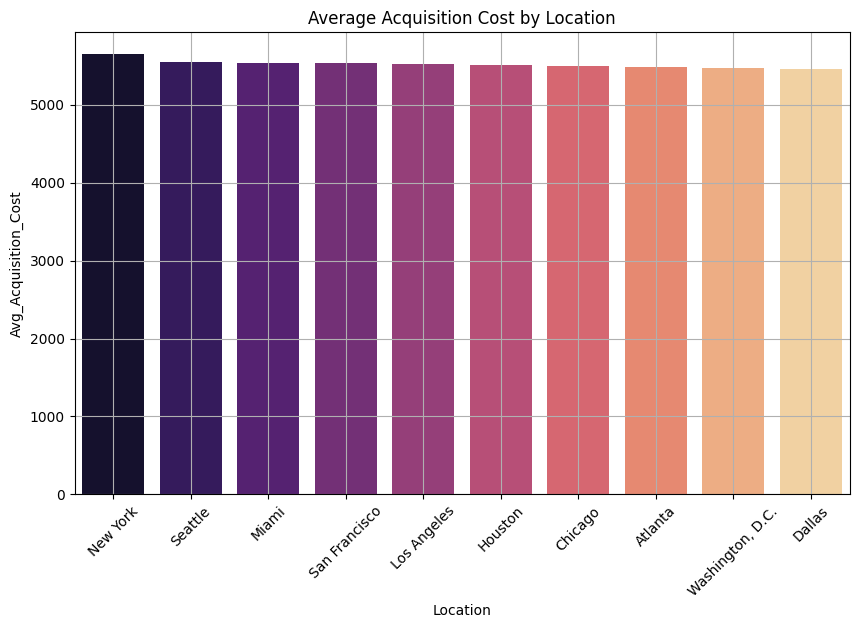

In [37]:
#Bar Chart: Location with Highest Acquisition Cost

location_cost_df = df.groupBy("Location") \
                     .agg(avg("Acquisition_Cost").alias("Avg_Acquisition_Cost")) \
                     .dropna().orderBy("Avg_Acquisition_Cost", ascending=False)

location_cost_pd = location_cost_df.toPandas()

plt.figure(figsize=(10,6))
sns.barplot(data=location_cost_pd, x="Location", y="Avg_Acquisition_Cost", palette="magma",hue= "Location")
plt.title("Average Acquisition Cost by Location")
plt.xticks(rotation=45)
plt.grid(True)
plt.show()


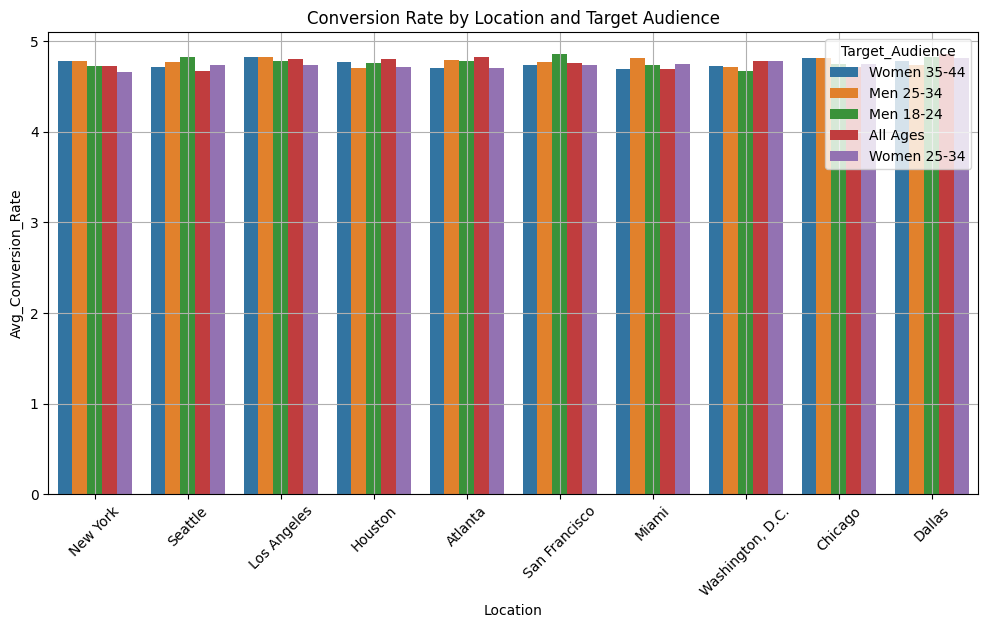

In [38]:
# Bar Chart: Conversion Rate by Location & Target Audience

conv_by_loc = df.groupBy("Location", "Target_Audience") \
                .agg(avg("Conversion_Rate").alias("Avg_Conversion_Rate")) \
                .dropna()

conv_by_loc_pd = conv_by_loc.toPandas()

plt.figure(figsize=(12,6))
sns.barplot(data=conv_by_loc_pd, x="Location", y="Avg_Conversion_Rate", hue="Target_Audience")
plt.title("Conversion Rate by Location and Target Audience")
plt.xticks(rotation=45)
plt.grid(True)
plt.show()


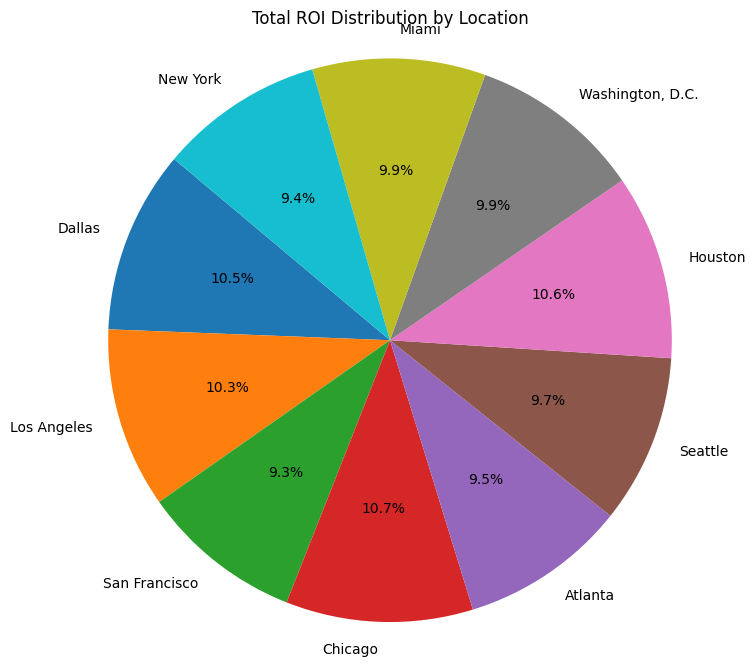

In [39]:
#Pie Chart: ROI Proportion by Location

roi_loc_df = df.groupBy("Location") \
               .agg({"ROI": "sum"}) \
               .withColumnRenamed("sum(ROI)", "Total_ROI") \
               .dropna()

roi_loc_pd = roi_loc_df.toPandas()

plt.figure(figsize=(8,8))
plt.pie(roi_loc_pd["Total_ROI"], labels=roi_loc_pd["Location"], autopct='%1.1f%%', startangle=140)
plt.title("Total ROI Distribution by Location")
plt.axis('equal')
plt.show()
